In [10]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")

import pickle
import time

import torch

import matplotlib.pyplot as plt
import defmod as dm
import model_graddesc as model


import defmod.multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.hamiltonian_multishape as hamiltonian
import defmod.save_results as results
import defmod.optimize


torch.set_default_tensor_type(torch.DoubleTensor)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
#%%
dty = torch.float64
#source = torch.tensor([[-1., -1.], [1., 1.], [1., -1.], [-1., 1.]], requires_grad=True, dtype=dty)
#target = torch.tensor([[0., 0.], [2., 0.], [1., -1.], [1., 1.]], requires_grad=True, dtype=dty)

#target = torch.tensor([[-2., -2.], [2., 2.], [2., -2.], [-2., 2.]], requires_grad=True, dtype=dty)
#target = 1.+ torch.tensor([[-1., -1.], [1., 1.], [1., -1.], [-1., 1.]], requires_grad=True, dtype=dty)
def close_loop(oc):
    cc = np.zeros((np.shape(oc)[0]+1,2))
    cc[0:-1,:] = oc
    cc[-1][:] = oc[0][:]
    return cc
#%%


with open('../data/nuts/nutsdata.pickle', 'rb') as f:
    lines, sigv, sig = pickle.load(f)
source = torch.tensor(lines[0][::2], requires_grad=True, dtype=dty)[1:]

target = torch.tensor(lines[1][::2]  , requires_grad=True, dtype=dty)[1:]
num_target = 1

#target = torch.tensor(lines[7][::2]  , requires_grad=True, dtype=dty)[1:]
#num_target = 7

targets = [target]



pts_source = source.detach().numpy()
pts_target = target.detach().numpy()

#%%


sigma_scaling = 1.

#%%
#gd0 = torch.tensor([[-1., 0.6]], requires_grad=True, dtype=dty)
gd0 = torch.tensor([[-1., 0.]], requires_grad=True, dtype=dty)
cotan0 = torch.tensor([[0., 0.]], requires_grad=True, dtype=dty)
#gd1 = torch.tensor([[0.8, 0.6]], requires_grad=True, dtype=dty)
gd1 = torch.tensor([[1., 0.]], requires_grad=True, dtype=dty)
cotan1 = torch.tensor([[0., 0.]], requires_grad=True, dtype=dty)
#%%

In [2]:
scaling0 = dm.deformationmodules.LocalScaling(dm.manifold.Landmarks(2, 1, gd = gd0.view(-1), cotan = cotan0.view(-1)),sigma_scaling)
scaling1 = dm.deformationmodules.LocalScaling(dm.manifold.Landmarks(2, 1, gd = gd1.view(-1), cotan = cotan1.view(-1)), sigma_scaling)

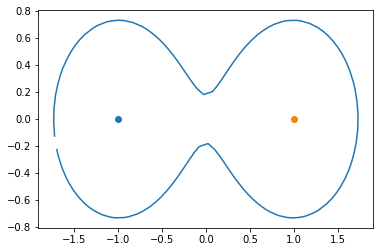

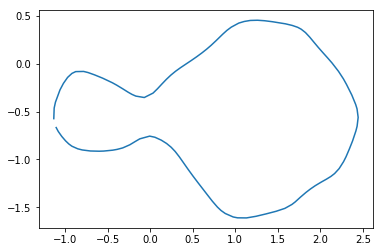

In [3]:
plt.figure()
plt.plot(pts_source[:,0], pts_source[:,1])
plt.scatter(gd0.detach().numpy()[:,0],gd0.detach().numpy()[:,1])
plt.scatter(gd1.detach().numpy()[:,0],gd1.detach().numpy()[:,1])

plt.show()

plt.figure()
plt.plot(pts_target[:,0], pts_target[:,1])
plt.show()


In [4]:
sigma_scaling = 1.
a = torch.sqrt(torch.tensor(3.))
direc_scaling_pts = torch.tensor([[1., 0.], [-0.5 , 0.5* a],  [-0.5, -0.5* a]], requires_grad=True, dtype=dty)
direc_scaling_vec =  torch.tensor([[1., 0.], [-0.5 , 0.5* a],  [-0.5, -0.5* a]], requires_grad=True, dtype=dty)
def f(x):
    centre = x.view(1,2).repeat(3,1)
    return centre + 0.3 * sigma_scaling * direc_scaling_pts

def g(x):
    return direc_scaling_vec
#%%
#gd0 = torch.tensor([[-1., 0.6]], requires_grad=True, dtype=dty)
gd0 = torch.tensor([[-1., 0.]], requires_grad=True, dtype=dty)
cotan0 = torch.tensor([[0., 0.]], requires_grad=True, dtype=dty)
#gd1 = torch.tensor([[0.8, 0.6]], requires_grad=True, dtype=dty)
gd1 = torch.tensor([[1., 0.]], requires_grad=True, dtype=dty)
cotan1 = torch.tensor([[0., 0.]], requires_grad=True, dtype=dty)
#%%
pts = f(gd0).detach().numpy()
vec = g(gd0).detach().numpy()
pts1 = f(gd1).detach().numpy()
vec1 = g(gd1).detach().numpy()


plt.quiver(pts[:,0], pts[:,1], vec[:,0], vec[:,1])
plt.quiver(pts1[:,0], pts1[:,1], vec1[:,0], vec1[:,1])
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], 'b')
plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'r')
plt.axis('equal')
#%%
scaling0 = dm.deformationmodules.ConstrainedTranslations(dm.manifold.Landmarks(2, 1, gd = gd0.view(-1), cotan = cotan0.view(-1)), f, g, sigma_scaling)
scaling1 = dm.deformationmodules.ConstrainedTranslations(dm.manifold.Landmarks(2, 1, gd = gd1.view(-1), cotan = cotan1.view(-1)), f, g, sigma_scaling)


In [36]:
scaling0 = dm.deformationmodules.ConstrainedTranslations_Scaling(dm.manifold.Landmarks(2, 1, gd = gd0.view(-1), cotan = cotan0.view(-1)), sigma_scaling)
scaling1 = dm.deformationmodules.ConstrainedTranslations_Scaling(dm.manifold.Landmarks(2, 1, gd = gd1.view(-1), cotan = cotan1.view(-1)), sigma_scaling)

In [37]:
silent = dm.deformationmodules.SilentPoints(dm.manifold.Landmarks(2, len(source), gd=source.view(-1)))
#silent_comp = dm.deformationmodules.CompoundModule([silent])
trans = dm.deformationmodules.Translations(dm.manifold.Landmarks(2,1,gd = torch.tensor([0.,0.]).view(-1)), sigma=400, coeff=5.)
trans1 = dm.deformationmodules.Translations(dm.manifold.Landmarks(2, len(source), gd=source.view(-1)), sigma=0.2, coeff=10.)
mod = dm.deformationmodules.CompoundModule([silent, scaling0, scaling1, trans1, trans])
h = dm.hamiltonian.Hamiltonian(mod)

In [38]:
def attach(x,y):
    return dm.attachement.VarifoldAttachement([1, 0.2])([x], [y])

EnergyFunctional = model.EnergyFunctional_unconstrained(mod, h, source, targets, dim=2, gamma=0.01, attach=attach)

In [39]:
gd0_tensor = torch.cat(h.module.manifold.unroll_gd(),0).requires_grad_().view(-1)
mom0_tensor = torch.zeros(gd0_tensor.shape).requires_grad_().view(-1)
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
X = [gd0_tensor, mom0_tensor]
X[1] = dm.optimize.BFGS(EnergyFunctional, X, disp=True)(maxiter=25)

cost: 0.0 attach: 12.933211334882209
cost: 0.0 attach: 12.933211334882209
cost: 0.249003474604 attach: 38.94263983725411
cost: 0.249003474604 attach: 38.94263983725411
cost: 0.0108196816368 attach: 7.5651484830741484
cost: 0.0108196816368 attach: 7.5651484830741484
cost: 0.0397955983564 attach: 11.12805025094169
cost: 0.0397955983564 attach: 11.12805025094169
cost: 0.0163350750711 attach: 5.182488052873126
cost: 0.0163350750711 attach: 5.182488052873126
cost: 0.0351003326557 attach: 9.583661887694056
cost: 0.0351003326557 attach: 9.583661887694056
cost: 0.0182899005643 attach: 4.4965746113761735
cost: 0.0182899005643 attach: 4.4965746113761735
cost: 0.0253017376433 attach: 9.046931285039687
cost: 0.0253017376433 attach: 9.046931285039687
cost: 0.0186145523577 attach: 4.4244620589175865
cost: 0.0186145523577 attach: 4.4244620589175865
cost: 0.0186476998213 attach: 4.281281782501667
cost: 0.0186476998213 attach: 4.281281782501667
cost: 0.0189111248272 attach: 3.754799219347473
cost: 0.01

In [40]:
h.module.manifold.fill_gd(X[0])
h.module.manifold.fill_cotan(X[1])

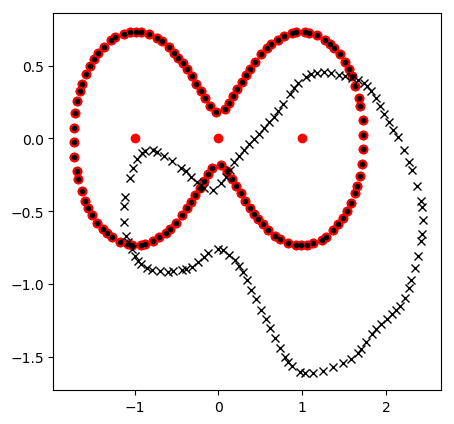

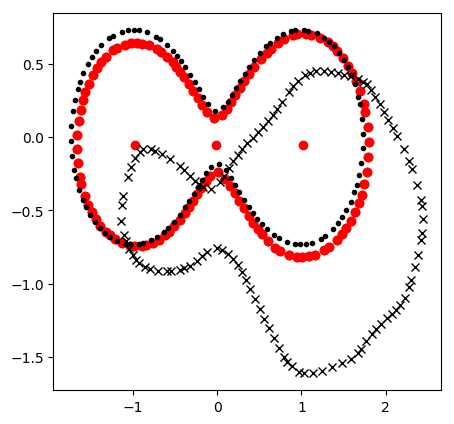

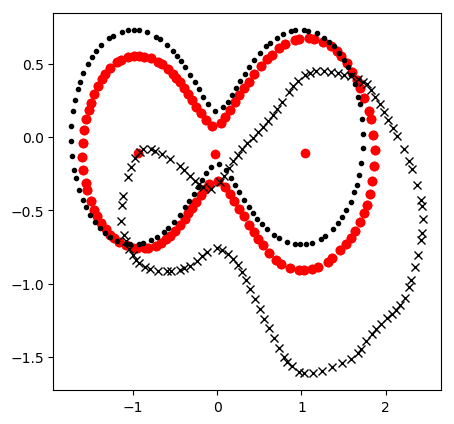

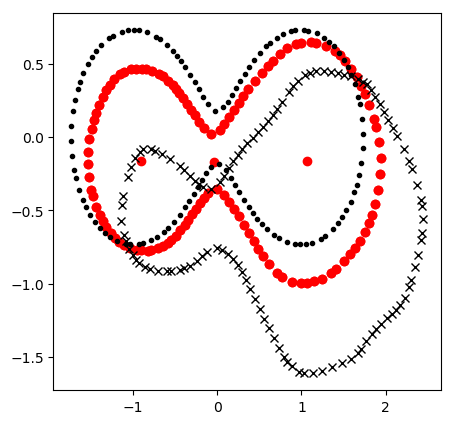

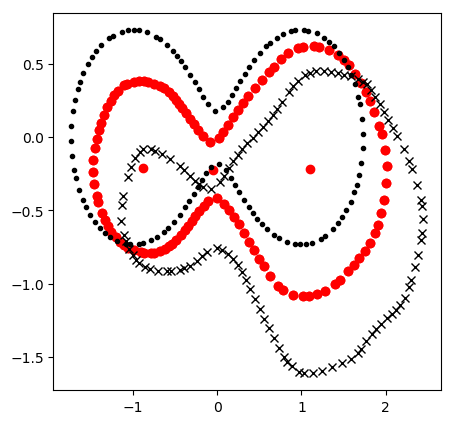

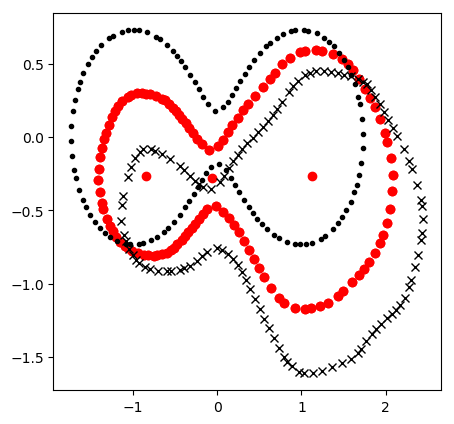

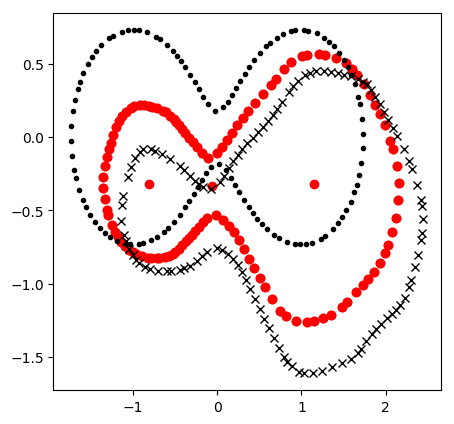

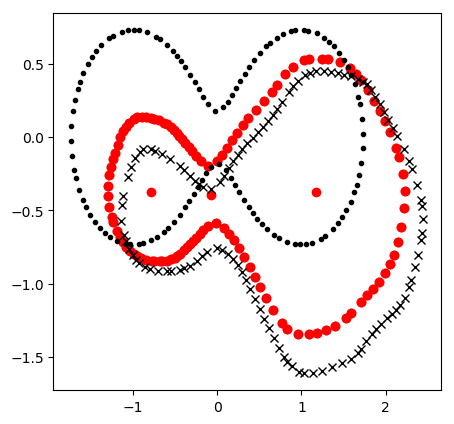

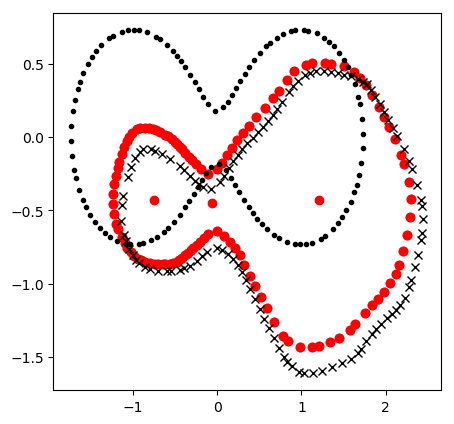

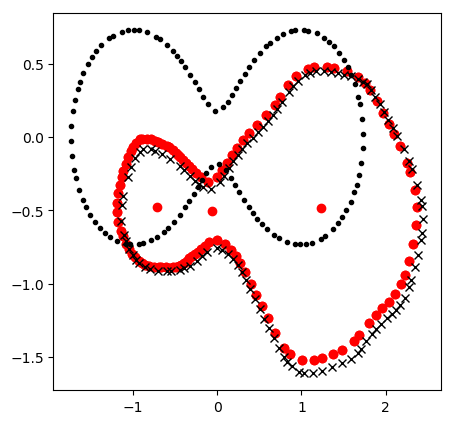

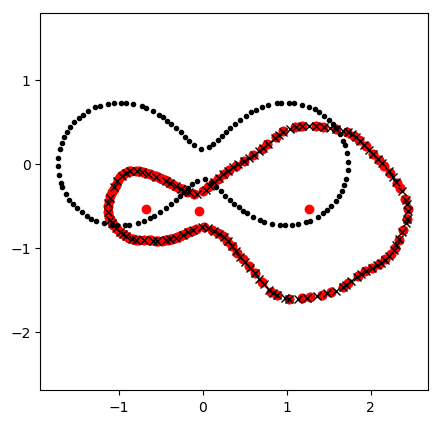

In [41]:
save = results.Save_Results_SingleShape(h, [source], [target])

save.fig_states(True)

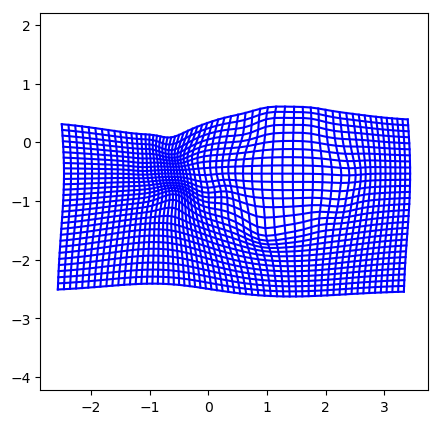

In [28]:
xlim = [-3, 3]
ylim = [-2,1]
d = [0.1, 0.1]
_ = save.gridpoints(xlim, ylim, d)


save.fig_grid(True)

In [31]:
H=h

In [32]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        H.geodesic_controls()
        
        return H()
    
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), raise_exception=True)

gd0_tensor = torch.cat(H.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
gd = gd0_tensor
mom = 1000*torch.rand(gd.shape)


test_gradcheck_Hamiltonian()

RuntimeError: Jacobian mismatch for output 0 with respect to input 0,
numerical:tensor([[ 3.5195e+06],
        [ 5.3382e+06],
        [ 3.7462e+06],
        [ 9.7653e+04],
        [ 3.3111e+05],
        [ 2.6619e+06],
        [ 4.7409e+06],
        [ 6.4032e+06],
        [ 2.3050e+06],
        [ 5.8923e+06],
        [ 5.3059e+06],
        [ 6.2368e+06],
        [ 4.2797e+06],
        [ 1.8547e+06],
        [ 1.0047e+06],
        [ 3.3748e+06],
        [ 1.9909e+06],
        [ 8.8750e+05],
        [ 1.1399e+06],
        [ 2.1912e+06],
        [ 3.7611e+06],
        [ 3.5169e+06],
        [ 6.5879e+06],
        [ 1.6163e+06],
        [ 1.6142e+06],
        [ 2.6532e+06],
        [ 3.1624e+06],
        [ 1.9792e+06],
        [ 3.6432e+06],
        [ 4.2945e+05],
        [ 4.6230e+06],
        [ 7.1082e+05],
        [-1.5937e+06],
        [ 1.8320e+06],
        [ 4.6633e+06],
        [ 2.1224e+04],
        [ 3.4519e+06],
        [-6.6998e+05],
        [-2.3209e+06],
        [ 1.2564e+06],
        [ 7.7005e+06],
        [-3.1475e+06],
        [ 8.3954e+05],
        [-3.6191e+05],
        [ 5.7281e+05],
        [-3.2718e+05],
        [ 1.5087e+06],
        [-9.6561e+05],
        [ 2.1280e+06],
        [-1.4985e+06],
        [-1.5318e+06],
        [ 4.6473e+05],
        [-5.2905e+04],
        [-1.9703e+05],
        [ 1.3574e+06],
        [-1.0038e+06],
        [ 2.8258e+06],
        [-1.7200e+06],
        [ 7.4575e+05],
        [-8.6935e+05],
        [-2.7404e+05],
        [-2.5281e+04],
        [ 6.8836e+04],
        [-3.4606e+05],
        [-9.2347e+05],
        [-1.0345e+06],
        [-3.0641e+06],
        [-2.4500e+06],
        [-3.3965e+06],
        [-2.8426e+06],
        [-1.3046e+06],
        [-1.1043e+06],
        [-1.8180e+06],
        [-1.5899e+06],
        [-2.3686e+06],
        [-2.2549e+06],
        [-3.3033e+06],
        [-2.3851e+06],
        [-2.3798e+06],
        [-1.6772e+06],
        [-6.5564e+06],
        [-4.2652e+06],
        [-4.4148e+06],
        [-3.8376e+06],
        [-6.6084e+06],
        [-3.6487e+06],
        [-2.5837e+06],
        [-2.3015e+06],
        [-6.8052e+06],
        [-4.4354e+06],
        [-2.1646e+06],
        [-2.3360e+06],
        [-1.7852e+06],
        [-2.9182e+06],
        [-6.5726e+06],
        [-2.6226e+06],
        [-2.0345e+06],
        [-2.5615e+06],
        [-5.1141e+06],
        [-1.5514e+06],
        [-1.7145e+05],
        [-8.2918e+05],
        [-9.1468e+05],
        [-9.1895e+05],
        [-2.0086e+06],
        [-3.9981e+05],
        [-5.4059e+06],
        [-9.5446e+05],
        [-4.1347e+06],
        [-1.2502e+06],
        [-5.5154e+06],
        [-2.4198e+06],
        [-5.6054e+06],
        [-6.0990e+05],
        [-2.3009e+06],
        [ 3.2222e+05],
        [-4.1608e+06],
        [-2.0279e+06],
        [-2.4414e+06],
        [-1.0798e+06],
        [-7.2172e+05],
        [-1.9362e+06],
        [-5.3931e+05],
        [-2.7832e+06],
        [-3.8393e+06],
        [-2.7405e+06],
        [-1.1233e+06],
        [-1.4435e+06],
        [-6.9222e+06],
        [-6.0960e+06],
        [-3.2545e+06],
        [-4.4854e+06],
        [-6.0305e+06],
        [-3.1897e+06],
        [-1.6795e+06],
        [-2.5565e+06],
        [-5.0588e+06],
        [-3.9089e+06],
        [-4.5096e+06],
        [-1.8278e+06],
        [-7.8028e+06],
        [-1.7891e+06],
        [-7.6565e+06],
        [-1.2684e+06],
        [-5.8446e+06],
        [-2.2026e+06],
        [-4.6974e+06],
        [-7.7274e+05],
        [-4.1337e+06],
        [-2.7707e+05],
        [-1.2202e+05],
        [-5.3652e+05],
        [-7.2014e+05],
        [-1.8276e+05],
        [ 4.1420e+05],
        [-1.2739e+06],
        [-4.2951e+06],
        [ 1.0941e+06],
        [-3.5728e+06],
        [ 2.3301e+05],
        [-5.1931e+06],
        [ 1.7392e+06],
        [-4.0422e+06],
        [ 1.5056e+06],
        [-3.2204e+06],
        [ 9.4472e+05],
        [-6.7771e+05],
        [-4.1427e+05],
        [ 9.8805e+05],
        [-1.2647e+06],
        [-3.2008e+06],
        [ 1.8861e+06],
        [-2.8487e+06],
        [ 1.8727e+06],
        [ 5.2998e+05],
        [-5.8802e+05],
        [ 1.6580e+04],
        [-5.2575e+05],
        [ 2.0907e+05],
        [-5.2601e+05],
        [-2.8748e+05],
        [-1.7331e+04],
        [ 1.3765e+06],
        [-8.4165e+05],
        [ 2.0004e+06],
        [ 5.8297e+05],
        [ 1.3858e+06],
        [ 4.7064e+05],
        [ 4.3575e+06],
        [ 2.2179e+06],
        [ 3.6797e+06],
        [ 1.1494e+06],
        [ 4.6876e+06],
        [ 2.5408e+06],
        [ 2.9509e+06],
        [ 1.7248e+06],
        [ 5.0317e+06],
        [ 2.6693e+06],
        [ 3.3631e+06],
        [ 1.8472e+06],
        [ 7.6141e+06],
        [ 4.1632e+06],
        [ 8.2587e+06],
        [ 4.3693e+06],
        [ 4.6072e+06],
        [ 2.1613e+06],
        [ 7.2595e+06],
        [ 4.0030e+06],
        [ 7.0360e+05],
        [ 3.4691e+05],
        [ 1.0769e+07],
        [ 4.9820e+06],
        [ 8.7865e+06],
        [ 2.7519e+06],
        [ 2.3386e+06],
        [ 6.6783e+05],
        [ 8.1323e+06],
        [ 4.0655e+06],
        [ 1.7712e+06],
        [ 2.9984e+06],
        [ 2.0312e+05],
        [ 1.3104e+06],
        [ 4.0029e+06],
        [ 3.2785e+06],
        [ 6.0632e+06],
        [ 3.7949e+06],
        [ 5.3458e+06],
        [ 1.1298e+06],
        [ 3.2109e+05],
        [ 1.1555e+06],
        [ 1.1921e+06],
        [ 1.9562e+06],
        [ 7.5936e+05],
        [-7.4101e+04],
        [ 2.8244e+06],
        [ 1.8054e+06],
        [ 1.1243e+05],
        [ 3.4442e+06],
        [ 3.7437e+06],
        [ 4.0125e+06],
        [-1.2062e+08],
        [-3.2484e+08],
        [ 1.3581e+08],
        [ 3.0518e+08],
        [ 4.0321e+06],
        [ 2.9897e+06],
        [ 2.0267e+06],
        [ 9.3933e+05],
        [ 7.3320e+05],
        [ 2.4774e+06],
        [ 3.1125e+06],
        [ 5.2643e+06],
        [ 2.3155e+06],
        [ 9.7609e+05],
        [ 3.7258e+06],
        [ 9.9444e+05],
        [ 4.5781e+06],
        [ 5.3948e+06],
        [ 1.7182e+06],
        [ 4.6999e+06],
        [ 1.9597e+06],
        [ 6.3770e+05],
        [ 9.0720e+05],
        [ 2.0579e+06],
        [ 3.0642e+06],
        [ 3.7911e+05],
        [ 2.6625e+06],
        [ 4.0803e+05],
        [ 3.2506e+06],
        [ 1.8920e+06],
        [ 2.8589e+06],
        [ 4.5313e+05],
        [ 7.0865e+06],
        [-4.9114e+05],
        [ 4.3348e+06],
        [-4.2058e+05],
        [ 4.1822e+05],
        [ 2.4231e+05],
        [ 3.2405e+06],
        [ 1.5816e+05],
        [ 2.2039e+06],
        [-3.0792e+05],
        [ 3.3228e+06],
        [-1.0749e+06],
        [ 3.4929e+06],
        [-1.3330e+06],
        [ 4.2950e+06],
        [-1.9759e+06],
        [-1.5760e+05],
        [-1.7501e+05],
        [ 3.0901e+06],
        [-3.7640e+05],
        [-1.1454e+06],
        [-3.2924e+06],
        [ 7.4176e+06],
        [ 2.3667e+06],
        [-3.5150e+06],
        [-6.5343e+06],
        [ 7.1110e+06],
        [ 4.2587e+06],
        [-1.8117e+06],
        [-4.7232e+06],
        [ 3.8062e+05],
        [ 1.5158e+06],
        [ 5.9064e+05],
        [-1.0420e+06],
        [ 5.3055e+05],
        [-1.6254e+06],
        [-2.0303e+06],
        [-1.5986e+06],
        [-1.0237e+06],
        [-8.9761e+05],
        [-2.1490e+06],
        [-1.7588e+06],
        [-6.2833e+05],
        [-6.4396e+05],
        [-2.9461e+06],
        [-2.0592e+06],
        [-2.2296e+06],
        [-1.8784e+06],
        [-4.8818e+06],
        [-4.0006e+06],
        [-1.6316e+06],
        [-1.2624e+06],
        [-2.5066e+06],
        [-2.2878e+06],
        [-7.2004e+06],
        [-3.9976e+06],
        [-5.6988e+06],
        [-2.8000e+06],
        [-6.2995e+06],
        [-4.5405e+06],
        [-2.4174e+06],
        [-2.3058e+06],
        [-8.2799e+06],
        [-3.3776e+06],
        [-7.6506e+06],
        [-2.2778e+06],
        [-5.2192e+06],
        [-1.9350e+06],
        [-1.9445e+06],
        [-1.9552e+06],
        [-3.0362e+06],
        [-1.6953e+06],
        [-5.1082e+06],
        [-7.2918e+05],
        [-2.3316e+06],
        [-2.6625e+06],
        [-4.2211e+06],
        [-2.3822e+04],
        [-2.7094e+06],
        [-2.5492e+06],
        [-1.9740e+06],
        [-2.2646e+06],
        [-6.0100e+05],
        [-2.7309e+06],
        [-4.7288e+06],
        [-1.3821e+06],
        [-4.4625e+06],
        [-3.4298e+05],
        [-5.2573e+06],
        [ 1.4994e+06],
        [ 3.4734e+04],
        [-2.0138e+06],
        [-8.5631e+05],
        [-7.0052e+05],
        [-6.3078e+05],
        [-2.3779e+06],
        [-4.5969e+06],
        [-4.1645e+06],
        [-1.8384e+06],
        [-2.2236e+06],
        [-6.9084e+06],
        [-5.2663e+06],
        [-4.3316e+06],
        [-4.9405e+06],
        [-3.4132e+06],
        [-3.5002e+06],
        [-2.1118e+06],
        [-5.0235e+05],
        [-2.9825e+06],
        [-3.5500e+06],
        [-4.5672e+05],
        [-6.4778e+05],
        [-8.6051e+06],
        [-3.6195e+06],
        [-6.0815e+06],
        [-2.7069e+06],
        [-7.2900e+06],
        [-5.5693e+05],
        [-8.1642e+06],
        [-1.2139e+06],
        [-7.3313e+06],
        [-5.6870e+04],
        [-6.2749e+06],
        [-3.4883e+05],
        [-3.3673e+06],
        [-1.9041e+05],
        [-6.8706e+06],
        [ 1.0555e+06],
        [-1.1026e+06],
        [ 9.6859e+04],
        [-5.5579e+06],
        [ 1.3324e+06],
        [-4.5745e+06],
        [ 1.5284e+06],
        [-4.2790e+06],
        [ 1.9998e+06],
        [ 3.8010e+05],
        [-1.0340e+06],
        [-4.1956e+06],
        [ 7.7511e+05],
        [-1.1391e+05],
        [ 3.7897e+06],
        [-4.5842e+06],
        [-4.4523e+06],
        [ 2.4272e+06],
        [ 7.2627e+06],
        [-6.0112e+06],
        [-5.1386e+06],
        [ 3.8329e+06],
        [ 2.9357e+06],
        [-1.4752e+06],
        [-1.4844e+06],
        [-1.4992e+05],
        [-5.5547e+04],
        [ 3.1416e+05],
        [ 1.1434e+05],
        [ 2.3659e+06],
        [-2.4329e+05],
        [ 2.1133e+06],
        [ 1.0351e+06],
        [ 5.3663e+06],
        [ 2.0770e+06],
        [ 3.2360e+06],
        [ 1.7428e+06],
        [ 7.1291e+06],
        [ 3.5847e+06],
        [ 2.9703e+06],
        [ 1.8812e+06],
        [ 5.9529e+06],
        [ 3.1170e+06],
        [ 3.2271e+06],
        [ 1.7481e+06],
        [ 3.1691e+06],
        [ 1.8340e+06],
        [ 5.6015e+06],
        [ 3.2330e+06],
        [ 8.0515e+06],
        [ 3.5980e+06],
        [ 1.0941e+07],
        [ 5.5282e+06],
        [ 8.2709e+05],
        [ 5.5455e+05],
        [ 3.3935e+06],
        [ 2.7096e+06],
        [ 7.3914e+06],
        [ 3.0700e+06],
        [ 5.1766e+06],
        [ 1.2914e+06],
        [ 3.1253e+06],
        [ 2.8061e+06],
        [ 2.7691e+06],
        [ 2.8059e+06],
        [ 5.7564e+06],
        [ 4.0239e+06],
        [ 1.4715e+06],
        [ 2.7631e+06],
        [ 2.8848e+06],
        [ 1.9818e+06],
        [ 7.5893e+05],
        [ 2.3544e+06],
        [ 4.9264e+06],
        [ 1.8650e+06],
        [ 4.8357e+06],
        [ 3.1896e+06],
        [ 2.5120e+06],
        [ 3.5468e+06],
        [ 2.6733e+06],
        [ 3.7859e+06],
        [ 2.2574e+06],
        [ 5.6284e+06],
        [ 2.0665e+06],
        [ 3.1500e+06],
        [ 5.7173e+05],
        [-1.0755e+06]])
analytical:tensor([[ 3.5195e+06],
        [ 5.3382e+06],
        [ 3.7462e+06],
        [ 9.7647e+04],
        [ 3.3111e+05],
        [ 2.6619e+06],
        [ 4.7409e+06],
        [ 6.4032e+06],
        [ 2.3050e+06],
        [ 5.8923e+06],
        [ 5.3059e+06],
        [ 6.2368e+06],
        [ 4.2797e+06],
        [ 1.8547e+06],
        [ 1.0047e+06],
        [ 3.3748e+06],
        [ 1.9909e+06],
        [ 8.8751e+05],
        [ 1.1399e+06],
        [ 2.1912e+06],
        [ 3.7611e+06],
        [ 3.5169e+06],
        [ 6.5879e+06],
        [ 1.6163e+06],
        [ 1.6142e+06],
        [ 2.6532e+06],
        [ 3.1624e+06],
        [ 1.9792e+06],
        [ 3.6432e+06],
        [ 4.2943e+05],
        [ 4.6230e+06],
        [ 7.1082e+05],
        [-1.5937e+06],
        [ 1.8320e+06],
        [ 4.6633e+06],
        [ 2.1233e+04],
        [ 3.4519e+06],
        [-6.6997e+05],
        [-2.3209e+06],
        [ 1.2565e+06],
        [ 7.7005e+06],
        [-3.1475e+06],
        [ 8.3954e+05],
        [-3.6191e+05],
        [ 5.7281e+05],
        [-3.2718e+05],
        [ 1.5087e+06],
        [-9.6561e+05],
        [ 2.1280e+06],
        [-1.4984e+06],
        [-1.5318e+06],
        [ 4.6473e+05],
        [-5.2898e+04],
        [-1.9705e+05],
        [ 1.3574e+06],
        [-1.0038e+06],
        [ 2.8258e+06],
        [-1.7201e+06],
        [ 7.4574e+05],
        [-8.6935e+05],
        [-2.7404e+05],
        [-2.5273e+04],
        [ 6.8844e+04],
        [-3.4605e+05],
        [-9.2346e+05],
        [-1.0345e+06],
        [-3.0641e+06],
        [-2.4500e+06],
        [-3.3965e+06],
        [-2.8426e+06],
        [-1.3046e+06],
        [-1.1043e+06],
        [-1.8180e+06],
        [-1.5899e+06],
        [-2.3686e+06],
        [-2.2549e+06],
        [-3.3033e+06],
        [-2.3851e+06],
        [-2.3798e+06],
        [-1.6772e+06],
        [-6.5564e+06],
        [-4.2652e+06],
        [-4.4148e+06],
        [-3.8376e+06],
        [-6.6084e+06],
        [-3.6487e+06],
        [-2.5837e+06],
        [-2.3015e+06],
        [-6.8052e+06],
        [-4.4354e+06],
        [-2.1646e+06],
        [-2.3360e+06],
        [-1.7852e+06],
        [-2.9182e+06],
        [-6.5726e+06],
        [-2.6226e+06],
        [-2.0345e+06],
        [-2.5615e+06],
        [-5.1141e+06],
        [-1.5514e+06],
        [-1.7144e+05],
        [-8.2919e+05],
        [-9.1466e+05],
        [-9.1896e+05],
        [-2.0086e+06],
        [-3.9980e+05],
        [-5.4059e+06],
        [-9.5446e+05],
        [-4.1347e+06],
        [-1.2502e+06],
        [-5.5154e+06],
        [-2.4198e+06],
        [-5.6054e+06],
        [-6.0991e+05],
        [-2.3009e+06],
        [ 3.2222e+05],
        [-4.1608e+06],
        [-2.0279e+06],
        [-2.4414e+06],
        [-1.0797e+06],
        [-7.2172e+05],
        [-1.9362e+06],
        [-5.3931e+05],
        [-2.7832e+06],
        [-3.8392e+06],
        [-2.7405e+06],
        [-1.1233e+06],
        [-1.4435e+06],
        [-6.9222e+06],
        [-6.0960e+06],
        [-3.2545e+06],
        [-4.4854e+06],
        [-6.0305e+06],
        [-3.1897e+06],
        [-1.6795e+06],
        [-2.5565e+06],
        [-5.0588e+06],
        [-3.9089e+06],
        [-4.5096e+06],
        [-1.8278e+06],
        [-7.8028e+06],
        [-1.7891e+06],
        [-7.6565e+06],
        [-1.2684e+06],
        [-5.8446e+06],
        [-2.2027e+06],
        [-4.6974e+06],
        [-7.7275e+05],
        [-4.1337e+06],
        [-2.7707e+05],
        [-1.2202e+05],
        [-5.3652e+05],
        [-7.2014e+05],
        [-1.8276e+05],
        [ 4.1420e+05],
        [-1.2739e+06],
        [-4.2951e+06],
        [ 1.0941e+06],
        [-3.5728e+06],
        [ 2.3300e+05],
        [-5.1931e+06],
        [ 1.7392e+06],
        [-4.0422e+06],
        [ 1.5056e+06],
        [-3.2204e+06],
        [ 9.4473e+05],
        [-6.7772e+05],
        [-4.1426e+05],
        [ 9.8805e+05],
        [-1.2647e+06],
        [-3.2008e+06],
        [ 1.8861e+06],
        [-2.8487e+06],
        [ 1.8727e+06],
        [ 5.2998e+05],
        [-5.8804e+05],
        [ 1.6580e+04],
        [-5.2575e+05],
        [ 2.0906e+05],
        [-5.2602e+05],
        [-2.8747e+05],
        [-1.7324e+04],
        [ 1.3765e+06],
        [-8.4166e+05],
        [ 2.0004e+06],
        [ 5.8296e+05],
        [ 1.3858e+06],
        [ 4.7064e+05],
        [ 4.3575e+06],
        [ 2.2179e+06],
        [ 3.6797e+06],
        [ 1.1494e+06],
        [ 4.6876e+06],
        [ 2.5408e+06],
        [ 2.9509e+06],
        [ 1.7248e+06],
        [ 5.0317e+06],
        [ 2.6693e+06],
        [ 3.3631e+06],
        [ 1.8472e+06],
        [ 7.6141e+06],
        [ 4.1632e+06],
        [ 8.2587e+06],
        [ 4.3693e+06],
        [ 4.6072e+06],
        [ 2.1612e+06],
        [ 7.2595e+06],
        [ 4.0030e+06],
        [ 7.0358e+05],
        [ 3.4691e+05],
        [ 1.0769e+07],
        [ 4.9820e+06],
        [ 8.7865e+06],
        [ 2.7519e+06],
        [ 2.3386e+06],
        [ 6.6783e+05],
        [ 8.1323e+06],
        [ 4.0655e+06],
        [ 1.7712e+06],
        [ 2.9984e+06],
        [ 2.0311e+05],
        [ 1.3104e+06],
        [ 4.0029e+06],
        [ 3.2785e+06],
        [ 6.0632e+06],
        [ 3.7949e+06],
        [ 5.3458e+06],
        [ 1.1298e+06],
        [ 3.2110e+05],
        [ 1.1555e+06],
        [ 1.1921e+06],
        [ 1.9562e+06],
        [ 7.5936e+05],
        [-7.4100e+04],
        [ 2.8244e+06],
        [ 1.8054e+06],
        [ 1.1243e+05],
        [ 3.4442e+06],
        [ 3.7437e+06],
        [ 4.0125e+06],
        [-1.2062e+08],
        [-3.2484e+08],
        [ 1.3581e+08],
        [ 3.0518e+08],
        [ 4.0321e+06],
        [ 2.9897e+06],
        [ 2.0267e+06],
        [ 9.3934e+05],
        [ 7.3320e+05],
        [ 2.4774e+06],
        [ 3.1125e+06],
        [ 5.2643e+06],
        [ 2.3155e+06],
        [ 9.7609e+05],
        [ 3.7258e+06],
        [ 9.9444e+05],
        [ 4.5781e+06],
        [ 5.3948e+06],
        [ 1.7182e+06],
        [ 4.6999e+06],
        [ 1.9597e+06],
        [ 6.3770e+05],
        [ 9.0719e+05],
        [ 2.0579e+06],
        [ 3.0642e+06],
        [ 3.7911e+05],
        [ 2.6625e+06],
        [ 4.0802e+05],
        [ 3.2506e+06],
        [ 1.8920e+06],
        [ 2.8589e+06],
        [ 4.5313e+05],
        [ 7.0865e+06],
        [-4.9113e+05],
        [ 4.3348e+06],
        [-4.2059e+05],
        [ 4.1821e+05],
        [ 2.4231e+05],
        [ 3.2405e+06],
        [ 1.5814e+05],
        [ 2.2039e+06],
        [-3.0793e+05],
        [ 3.3228e+06],
        [-1.0749e+06],
        [ 3.4929e+06],
        [-1.3330e+06],
        [ 4.2951e+06],
        [-1.9759e+06],
        [-1.5760e+05],
        [-1.7500e+05],
        [ 3.0902e+06],
        [-3.7604e+05],
        [-1.1468e+06],
        [-3.2952e+06],
        [ 7.4199e+06],
        [ 2.3707e+06],
        [-3.5168e+06],
        [-6.5367e+06],
        [ 7.1120e+06],
        [ 4.2599e+06],
        [-1.8118e+06],
        [-4.7234e+06],
        [ 3.8062e+05],
        [ 1.5158e+06],
        [ 5.9063e+05],
        [-1.0420e+06],
        [ 5.3053e+05],
        [-1.6254e+06],
        [-2.0303e+06],
        [-1.5986e+06],
        [-1.0237e+06],
        [-8.9761e+05],
        [-2.1490e+06],
        [-1.7588e+06],
        [-6.2825e+05],
        [-6.4402e+05],
        [-2.9462e+06],
        [-2.0590e+06],
        [-2.2296e+06],
        [-1.8784e+06],
        [-4.8818e+06],
        [-4.0006e+06],
        [-1.6316e+06],
        [-1.2624e+06],
        [-2.5066e+06],
        [-2.2878e+06],
        [-7.2004e+06],
        [-3.9977e+06],
        [-5.6988e+06],
        [-2.8000e+06],
        [-6.2995e+06],
        [-4.5405e+06],
        [-2.4174e+06],
        [-2.3058e+06],
        [-8.2799e+06],
        [-3.3776e+06],
        [-7.6506e+06],
        [-2.2778e+06],
        [-5.2192e+06],
        [-1.9350e+06],
        [-1.9445e+06],
        [-1.9552e+06],
        [-3.0362e+06],
        [-1.6953e+06],
        [-5.1082e+06],
        [-7.2919e+05],
        [-2.3316e+06],
        [-2.6625e+06],
        [-4.2211e+06],
        [-2.3823e+04],
        [-2.7094e+06],
        [-2.5492e+06],
        [-1.9740e+06],
        [-2.2646e+06],
        [-6.0101e+05],
        [-2.7309e+06],
        [-4.7288e+06],
        [-1.3821e+06],
        [-4.4625e+06],
        [-3.4297e+05],
        [-5.2573e+06],
        [ 1.4993e+06],
        [ 3.4731e+04],
        [-2.0138e+06],
        [-8.5632e+05],
        [-7.0053e+05],
        [-6.3078e+05],
        [-2.3778e+06],
        [-4.5969e+06],
        [-4.1646e+06],
        [-1.8384e+06],
        [-2.2236e+06],
        [-6.9084e+06],
        [-5.2663e+06],
        [-4.3316e+06],
        [-4.9405e+06],
        [-3.4133e+06],
        [-3.5002e+06],
        [-2.1118e+06],
        [-5.0233e+05],
        [-2.9825e+06],
        [-3.5500e+06],
        [-4.5671e+05],
        [-6.4779e+05],
        [-8.6051e+06],
        [-3.6195e+06],
        [-6.0815e+06],
        [-2.7069e+06],
        [-7.2900e+06],
        [-5.5694e+05],
        [-8.1642e+06],
        [-1.2139e+06],
        [-7.3313e+06],
        [-5.6869e+04],
        [-6.2749e+06],
        [-3.4883e+05],
        [-3.3673e+06],
        [-1.9041e+05],
        [-6.8706e+06],
        [ 1.0555e+06],
        [-1.1026e+06],
        [ 9.6857e+04],
        [-5.5579e+06],
        [ 1.3324e+06],
        [-4.5745e+06],
        [ 1.5284e+06],
        [-4.2790e+06],
        [ 1.9998e+06],
        [ 3.8009e+05],
        [-1.0340e+06],
        [-4.1957e+06],
        [ 7.7474e+05],
        [-1.1259e+05],
        [ 3.7926e+06],
        [-4.5866e+06],
        [-4.4563e+06],
        [ 2.4290e+06],
        [ 7.2651e+06],
        [-6.0122e+06],
        [-5.1397e+06],
        [ 3.8331e+06],
        [ 2.9359e+06],
        [-1.4752e+06],
        [-1.4844e+06],
        [-1.4992e+05],
        [-5.5552e+04],
        [ 3.1416e+05],
        [ 1.1434e+05],
        [ 2.3659e+06],
        [-2.4330e+05],
        [ 2.1133e+06],
        [ 1.0351e+06],
        [ 5.3663e+06],
        [ 2.0770e+06],
        [ 3.2359e+06],
        [ 1.7429e+06],
        [ 7.1292e+06],
        [ 3.5845e+06],
        [ 2.9703e+06],
        [ 1.8813e+06],
        [ 5.9529e+06],
        [ 3.1170e+06],
        [ 3.2271e+06],
        [ 1.7481e+06],
        [ 3.1691e+06],
        [ 1.8340e+06],
        [ 5.6015e+06],
        [ 3.2330e+06],
        [ 8.0515e+06],
        [ 3.5980e+06],
        [ 1.0941e+07],
        [ 5.5282e+06],
        [ 8.2709e+05],
        [ 5.5454e+05],
        [ 3.3935e+06],
        [ 2.7096e+06],
        [ 7.3914e+06],
        [ 3.0700e+06],
        [ 5.1766e+06],
        [ 1.2914e+06],
        [ 3.1253e+06],
        [ 2.8061e+06],
        [ 2.7691e+06],
        [ 2.8059e+06],
        [ 5.7564e+06],
        [ 4.0239e+06],
        [ 1.4715e+06],
        [ 2.7631e+06],
        [ 2.8848e+06],
        [ 1.9818e+06],
        [ 7.5892e+05],
        [ 2.3544e+06],
        [ 4.9264e+06],
        [ 1.8650e+06],
        [ 4.8356e+06],
        [ 3.1897e+06],
        [ 2.5120e+06],
        [ 3.5468e+06],
        [ 2.6733e+06],
        [ 3.7859e+06],
        [ 2.2574e+06],
        [ 5.6284e+06],
        [ 2.0665e+06],
        [ 3.1500e+06],
        [ 5.7171e+05],
        [-1.0755e+06]])
